## **Image Styling (5 points)**


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/Colab\ Notebooks/Assignment 2

/content/gdrive/MyDrive/Colab Notebooks/Assignment 2


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import cv2 
from google.colab.patches import cv2_imshow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import vgg19
from tensorflow import keras
from IPython import display

In [16]:
# Hyperparams
style_weight = 0.000002
content_weight = 1.0
variation_weight = 0.002
learning_rate = 5.0
ITERATIONS = 110

In [5]:
# Paths
content_image_path = "google.jpeg"         
style_image_path = "WarsawByTytusBrzozowski.jpg"

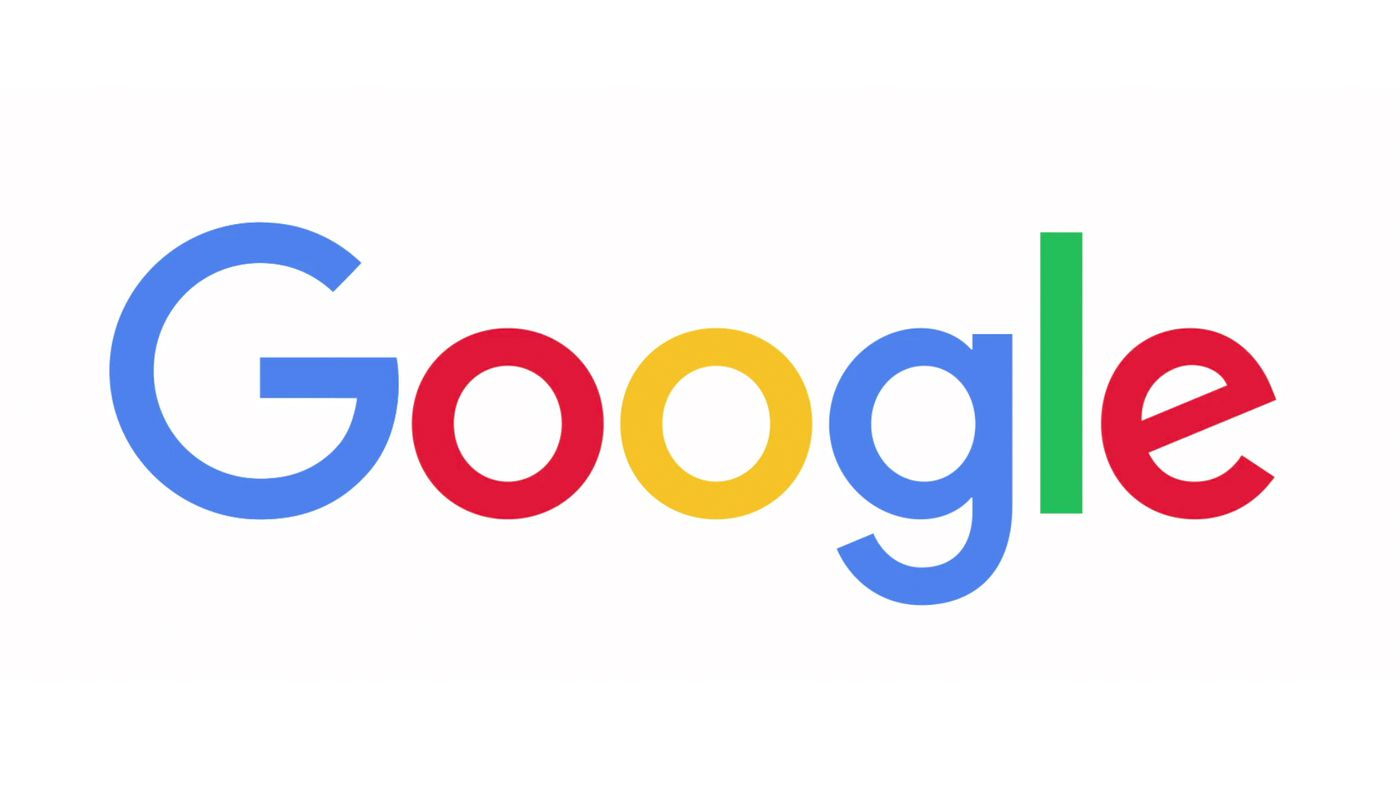

In [6]:
content_img = cv2.imread(content_image_path)

#percent by which the image is resized
scale_percent = 100

#calculate the 75 percent of original dimensions
width = int(content_img.shape[1] * scale_percent / 100)
height = int(content_img.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
content_img = cv2.resize(content_img, dsize)
cv2_imshow(content_img)

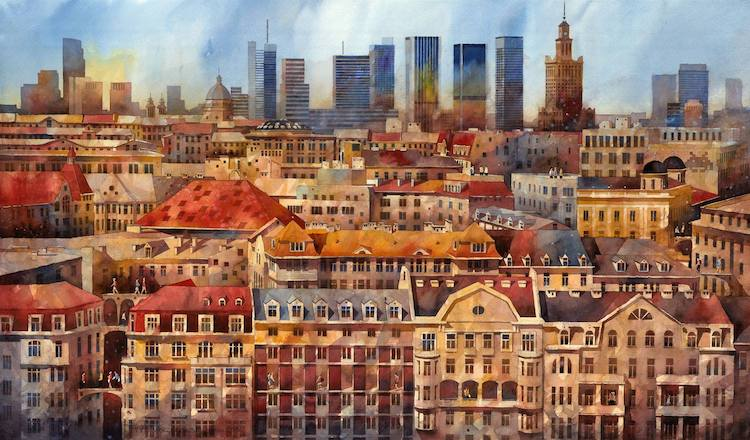

In [7]:
style_img = cv2.imread(style_image_path)

#percent by which the image is resized
scale_percent = 100

#calculate the 75 percent of original dimensions
width = int(style_img.shape[1] * scale_percent / 100)
height = int(style_img.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
style_img = cv2.resize(style_img, dsize)
cv2_imshow(style_img)

In [8]:
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]

# Content layer where will pull our feature maps
content_layers = ['block2_conv2']
# Style layer of interest
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]


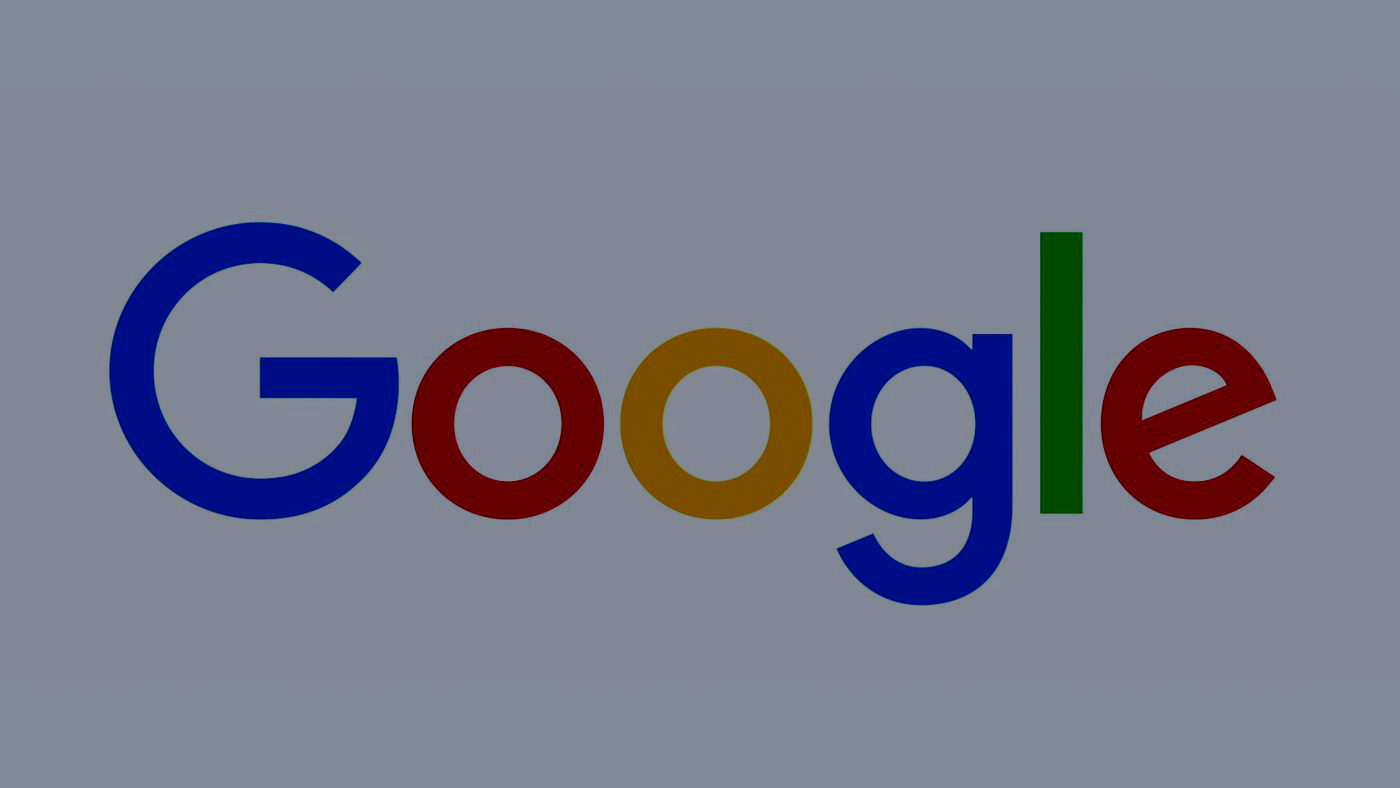

In [9]:
# Content Image
content_image = image.load_img(content_image_path, target_size=(content_img.shape[0], content_img.shape[1], 3))
content_image = image.img_to_array(content_image)
content_image = np.expand_dims(content_image, axis=0)
content_image_processed = vgg16.preprocess_input(content_image.copy())
cv2_imshow(content_image_processed[0])

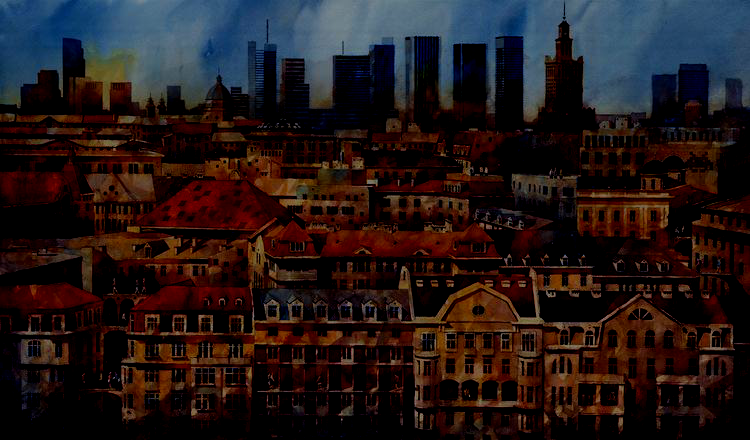

In [10]:
# Style Image
style_image = image.load_img(style_image_path, target_size=(style_img.shape[0], style_img.shape[1], 3))
style_image = image.img_to_array(style_image)
style_image = np.expand_dims(style_image, axis=0)
style_image_processed = vgg16.preprocess_input(style_image.copy())
cv2_imshow(style_image_processed[0])

In [11]:
# CNN Model
vgg_network = vgg16.VGG16(weights='imagenet', include_top=False)
vgg_network.trainalbe = False
vgg_network.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:
def train_step():
    with tf.GradientTape() as tape:
        # G(output_image)
        style_of_output = style_extractor(output_image)
        # F(output_image)
        content_of_output = content_extractor(output_image)

        # style loss
        style_loss = [tf.reduce_mean((output - target) ** 2) for output,target in zip(style_of_output, style_targets)]
        style_loss = style_weight * tf.reduce_mean(style_loss)

        # content loss
        content_loss = [tf.reduce_mean((output - target) ** 2)
                            for output,target in zip(content_of_output, content_targets)]
        content_loss = content_weight * tf.reduce_mean(content_loss)

        # variation loss
        x_deltas, y_deltas = 0., 0.
        for i in range(5):
            x_deltas += (output_image[:, :, i:-5+i, :] - output_image[:, :, 5:, :])
            y_deltas += (output_image[:, i:-5+i, :, :] - output_image[:, 5:, :, :])
        variation_loss =  variation_weight * (tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas)))

        loss = style_loss + content_loss + variation_loss

    # minize the loss by the optimizer
    grad = tape.gradient(loss, output_image)
    opt.apply_gradients([(grad, output_image)])

    return loss.numpy(), style_loss.numpy(), content_loss.numpy(), variation_loss.numpy()

Iteration 110: 
| total_loss | style_loss | content_loss | variation_loss |
|    98013.4 |     8218.8 |       9138.2 |       80656.4 |


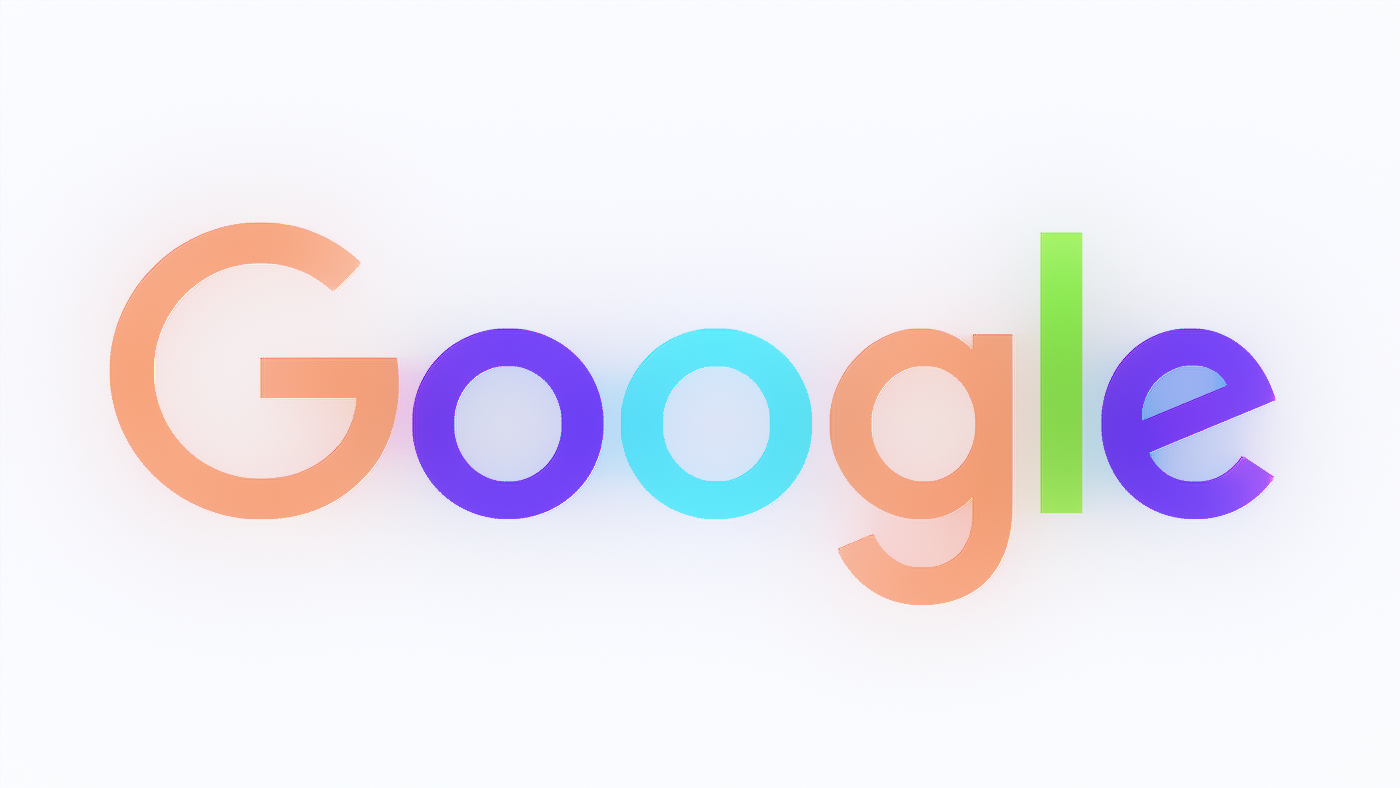

save to google_styled110.jpg


In [17]:
# Extract the Style Layers
style_extractor = keras.Model([vgg_network.input], [gram_matrix(vgg_network.get_layer(name).output) for name in style_layers])

# Extract the COntent Layers
content_extractor = keras.Model([vgg_network.input], [vgg_network.get_layer(name).output for name in content_layers])

# Output Image
output_image = tf.Variable(content_image_processed)
opt = tf.optimizers.Adam(learning_rate=learning_rate)


# G(style_image)
style_targets = style_extractor(style_image_processed)
# F(content_image)
content_targets = content_extractor(content_image_processed)

for i in range(ITERATIONS+1):
    loss, style_loss, content_loss, variation_loss = train_step()
    if i%10 == 0:
        display.clear_output(wait=True)
        print(f"Iteration {i}: ")
        print("| total_loss | style_loss | content_loss | variation_loss |")
        print("| {:10.1f} | {:10.1f} | {:12.1f} | {:13.1f} |".format(loss, 
                                style_loss, content_loss, variation_loss))
        file_name = f"{content_image_path.split('.')[0]}_styled{i}.jpg"
        # depreprocess it
        output = output_image[0, :, :, ::-1]
        output = output.numpy()
        output += IMAGENET_MEAN_RGB_VALUES
        output[output<0.] = 0.
        output[output>255.] = 255
        image.array_to_img(output).save(file_name)
        cv2_imshow(output)
        print('save to ' + file_name)

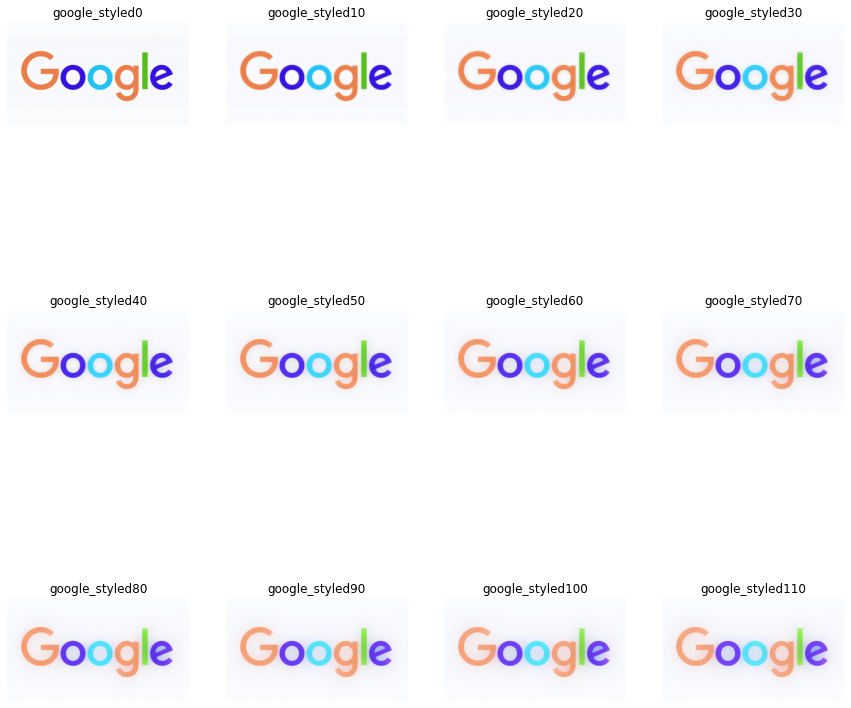

In [19]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
count = 0
for i in range(1, columns*rows + 1):
    img = cv2.imread(f"{content_image_path.split('.')[0]}_styled{count}.jpg")
    fig.add_subplot(rows, columns, i)
    plt.title(f"{content_image_path.split('.')[0]}_styled{count}")
    plt.axis('off')
    plt.imshow(np.squeeze(img).astype('int'))
    count = count + 10
plt.show()